# Clasificación de imágenes de personas con mascarilla con mejores datos


## 1. Importación de librerías


In [10]:
# General
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2


# Keras
import tensorflow as tf
import keras
from keras.src.utils import image_dataset_from_directory
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Input

from keras.models import Sequential, Model
from keras.utils import to_categorical

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam

## 2. Creación de dataframe y partición en train y test


In [11]:
# Cargar todas las imágenes sin dividir
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
data_dir = '/kaggle/input/face-mask/data'
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# Convertir el Dataset en un array para poder dividirlo
images = []
labels = []

# Cargar imágenes y etiquetas en listas (2 elementos dada la estructura de datos)
for image_batch, label_batch in full_ds:
    images.append(image_batch.numpy())
    labels.append(label_batch.numpy())

images = np.concatenate(images)
labels = np.concatenate(labels)

# Dividir el conjunto de datos en entrenamiento (80%), validación (10%) y test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

# Volver a convertir a datasets de TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

Found 7553 files belonging to 2 classes.


## 3. Normalización de imagenes


In [12]:
#normalization = Rescaling(1./255)
data_augmentation = Sequential([
 RandomFlip("horizontal"), # Volteo horizontal
 RandomRotation(0.2), # Rotaciones 20% de 360º
 RandomZoom(0.1), # Zoom hasta 10%
 RandomTranslation(0.1, 0.1) # Desplaz. vertical y horizontal
])

## 4. Entrenamiento del modelo


In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

model = keras.Sequential([
    Input(shape=(128, 128, 3)),
    data_augmentation,   
    Rescaling(1./255),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    #Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    #Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    #Dropout(0.5),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Para clasificación binaria
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      16,777,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,065,249 (65.10 MB)

 Trainable params: 17,065,249 (65.10 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
epochs = 30
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, batch_size=BATCH_SIZE, callbacks=[early_stopping, reduce_lr])

Epoch 1/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.7077 - loss: 0.5419 - val_accuracy: 0.8954 - val_loss: 0.2794 - learning_rate: 1.0000e-04
Epoch 2/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8568 - loss: 0.3498 - val_accuracy: 0.9033 - val_loss: 0.2488 - learning_rate: 1.0000e-04
Epoch 3/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8641 - loss: 0.3237 - val_accuracy: 0.9152 - val_loss: 0.2169 - learning_rate: 1.0000e-04
Epoch 4/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8737 - loss: 0.3041 - val_accuracy: 0.9099 - val_loss: 0.2108 - learning_rate: 1.0000e-04
Epoch 5/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8826 - loss: 0.2891 - val_accuracy: 0.9166 - val_loss: 0.2000 - learning_rate: 1.0000e-04
Epoch 6/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8814 - loss: 0.2782 - val_accuracy: 0.9126 - val_loss: 0.1912 - learning_rate: 1.0000e-04
Epoch 7/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - ac

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9508 - loss: 0.0983
Pérdida en test: 0.0915
Precisión en test: 0.9629


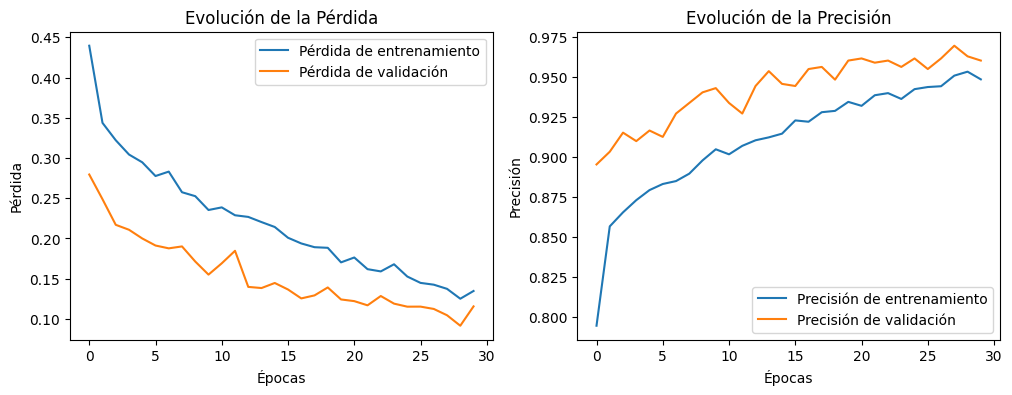

In [15]:
# Evaluación del modelo en el conjunto de test
loss, accuracy = model.evaluate(val_dataset)
print(f"Pérdida en test: {loss:.4f}")
print(f"Precisión en test: {accuracy:.4f}")
# Visualización de la evolución del entrenamiento
# Extraer los valores del historial
epochs_range = range(len(history.history['loss']))
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Pérdida de entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Evolución de la Pérdida')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Precisión de entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Evolución de la Precisión')
plt.show()


In [16]:
# Hacer las predicciones sobre el conjunto de prueba
predictions = model.predict(val_dataset)

# Convertir las predicciones en clases binarias
predicted_classes = (predictions > 0.5).astype(np.float32).flatten()

# Verificar las formas
# print(f"test_Y shape: {test_dataset.shape}")  # Usar labels en test_dataset
print(f"predicted_classes shape: {predicted_classes.shape}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
predicted_classes shape: (755,)


In [17]:
target_names = ["with_mask", "without_mask"]

# Hacer las predicciones y convertirlas en clases binarias
predicted_classes = (model.predict(val_dataset) > 0.5).astype(np.float32).flatten()

# Obtener las etiquetas reales de manera más eficiente
true_labels = np.concatenate([labels.numpy() for _, labels in val_dataset])

# Verificar las formas
print(f"true_labels shape: {true_labels.shape}")
print(f"predicted_classes shape: {predicted_classes.shape}")

# Mostrar el classification_report
print(classification_report(true_labels, predicted_classes, target_names=target_names))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
true_labels shape: (755, 1)
predicted_classes shape: (755,)
              precision    recall  f1-score   support

   with_mask       0.97      0.95      0.96       378
without_mask       0.95      0.97      0.96       377

    accuracy                           0.96       755
   macro avg       0.96      0.96      0.96       755
weighted avg       0.96      0.96      0.96       755



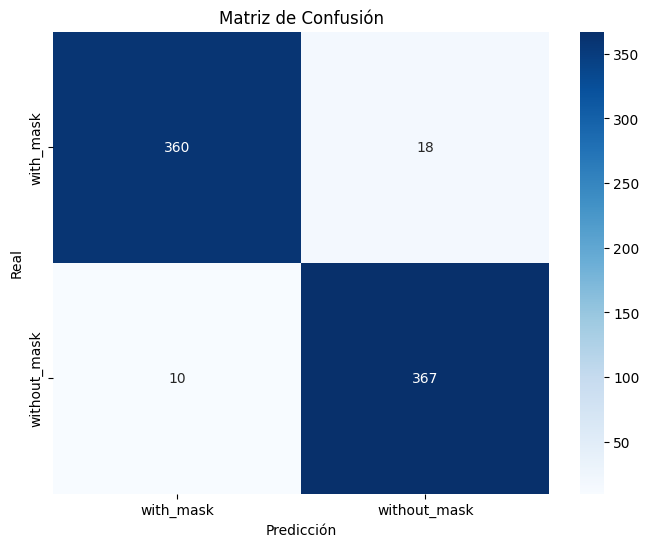

In [18]:
# Crear la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Mostrar matriz de confusión con heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()